#### Copyright 2018 Google LLC.

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Cat vs. Dog Image Classification


In [2]:
## Set These Parameters
last_layer_neurons = 1
last_layer_activation = 'sigmoid'
loss_function = 'binary_crossentropy'

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [4]:
!wget --no-check-certificate \
   https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
   /tmp/cats_and_dogs_filtered.zip

--2022-11-05 19:35:33--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 142.250.4.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  20.5MB/s    in 3.9s    

2022-11-05 19:35:37 (17.0 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [5]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
  
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

Next, let's apply the `datagen` transformations to a cat image from the training set to produce five random variants. Rerun the cell a few times to see fresh batches of random variants.

In [6]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    # shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

#
class_mode = 'binary' if last_layer_neurons == 1 else 'categorical'

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode=class_mode)

# Flow validation images in batches of 32 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode=class_mode)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


If we train a new network using this data augmentation configuration, our network will never see the same input twice. However the inputs that it sees are still heavily intercorrelated, so this might not be quite enough to completely get rid of overfitting.

## Building a Small ConvNet


In [7]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import optimizers

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(img_input) 
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x) 
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 128 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(128, 3, activation='relu')(x) 
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x) 

# Add a dropout rate of 0.5
x = layers.Dropout(0.2)(x)

# add output layer
output = layers.Dense(last_layer_neurons, activation=last_layer_activation)(x)

# Configure and compile the model
model = Model(img_input, output)
model.compile(loss=loss_function,
              optimizer=optimizers.RMSprop(lr=1e-3),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [8]:
history = model.fit(
      train_generator,
      epochs=50,
      validation_data=validation_generator,
      verbose=1)

Epoch 1/50
100/100 [==============================] - 26s 170ms/step - loss: 1.0517 - acc: 0.5320 - val_loss: 0.7808 - val_acc: 0.5040
Epoch 2/50
100/100 [==============================] - 17s 172ms/step - loss: 0.6865 - acc: 0.5945 - val_loss: 0.6428 - val_acc: 0.6050
Epoch 3/50
100/100 [==============================] - 17s 175ms/step - loss: 0.6332 - acc: 0.6540 - val_loss: 0.6802 - val_acc: 0.5950
Epoch 4/50
100/100 [==============================] - 17s 171ms/step - loss: 0.6202 - acc: 0.6575 - val_loss: 0.5646 - val_acc: 0.7000
Epoch 5/50
100/100 [==============================] - 17s 170ms/step - loss: 0.6041 - acc: 0.6865 - val_loss: 0.5735 - val_acc: 0.7080
Epoch 6/50
100/100 [==============================] - 17s 172ms/step - loss: 0.5879 - acc: 0.6990 - val_loss: 0.5335 - val_acc: 0.7320
Epoch 7/50
100/100 [==============================] - 17s 169ms/step - loss: 0.5754 - acc: 0.7005 - val_loss: 0.6246 - val_acc: 0.6890
Epoch 8/50
100/100 [==============================] - 1

Note that with data augmentation in place, the 2,000 training images are randomly transformed each time a new training epoch runs, which means that the model will never see the same image twice during training.

## Evaluate the Results

Let's evaluate the results of model training with data augmentation and dropout:

Text(0.5, 1.0, 'Training and validation loss')

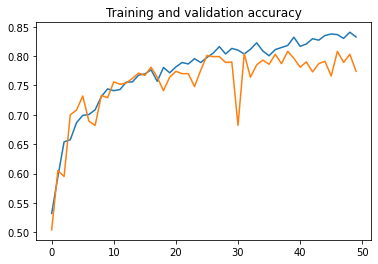

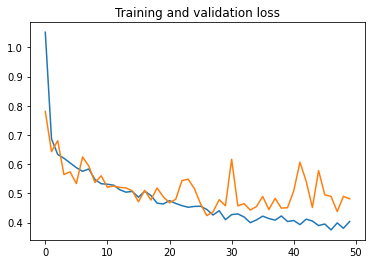

In [9]:
from matplotlib import pyplot as plt

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')